# Class 04
## ML Models: Naïve Bayes + Evaluation Metrics

We are going to work with classifier models today. We start with a sample dataset from Sebastian Thrun's Udacity Machine Learning course. Here's the scenario: we are building a self-driving car. We have mapped out the course we are taking and created a dataset that indicates, on a scale from 0 to 1, how bumpy the road is and, on the same scale, how steep the road is (measured in "grade"). For each road we need to know whether we should have the car drive "slow" or "fast". For example, we want to slow down for bumpy roads. But we may want to speed up when we are going up steep hills. I've created a sample dataset from fake data that maps this out. We start by loading and plotting the data.

'data.frame':	1000 obs. of  3 variables:
 $ Grade    : num  0.381 0.231 0.166 0.914 0.578 ...
 $ Bumpiness: num  0.116 0.456 0.873 0.393 0.304 ...
 $ Speed    : Factor w/ 2 levels "fast","slow": 2 2 1 1 1 1 1 1 1 1 ...
NULL


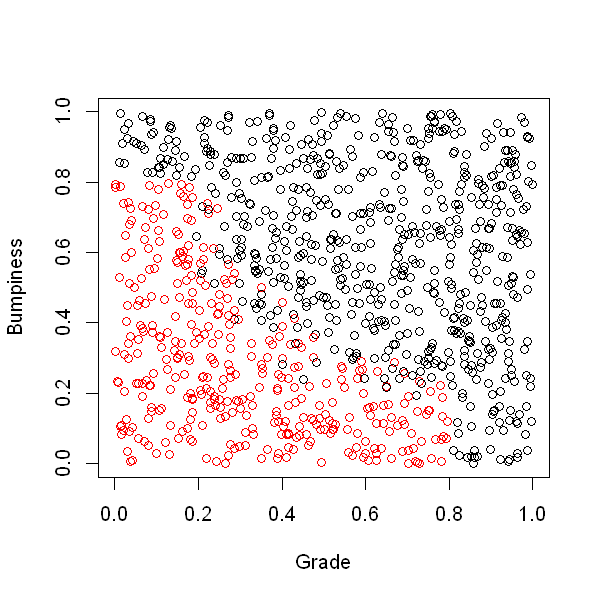

In [1]:
#Note that we didn't specify stringsAsFactors=FALSE. By default, this means that the factor column "Speed" will be converted
# to factors. We verify this by printing the structure of the dataframe
speeddf <- read.csv("Class04_speed_data.csv")
print(str(speeddf))
options(repr.plot.width=5, repr.plot.height=5)
plot(Bumpiness ~ Grade, col=Speed, speeddf)


We will start with a subset of this data to illustrate what we are trying to do here. We use the `sample()` function to get a small piece of the data (we use the random_state option to make sure we use the same set of data every time, otherwise the data will change).

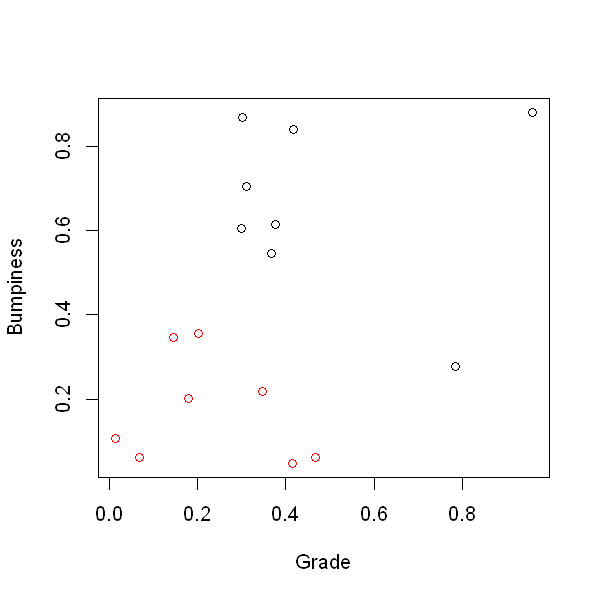

In [2]:
set.seed(60)
speedsub <- speeddf[sample(nrow(speeddf), 16), ]
plot(Bumpiness ~ Grade, col=Speed, speedsub)

What we want to do is have the computer learn where the boundary lies between the fast data points and the slow data points. That way we can input in any grade and any bumpiness and the computer will tell us whether to go fast or slow. It looks like there is a region between the two sets of data where we could potentially put our boundary.

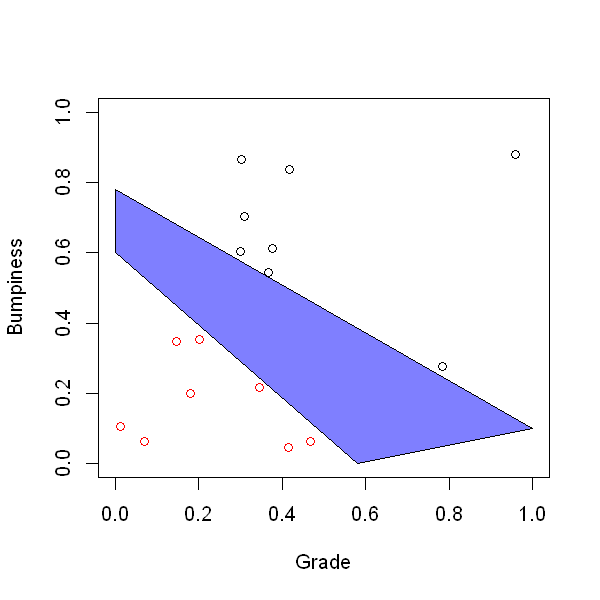

In [3]:
plot(Bumpiness ~ Grade, col=Speed, speedsub,xlim=c(0,1),ylim=c(0,1))

polygon(c(.58,1,0,0),c(0,.1,.78,.6),col=rgb(0,0,1,0.5))

How do we decide where in this region to put the boundary? There are a couple of different algorithms that will do the job for us. We're not going to spend time describing how they work - you can look them up if you are interested in the mathematics. Instead, we'll look at how to apply them and look at how well they work.

## Perceptron

The first algorithm is called the Perceptron (information on how it works is found on Wikipedia: https://en.wikipedia.org/wiki/Perceptron#Learning_algorithm). We'll use a syntax very similar to the pattern we used in Class02. First, we split the data into training and testing sets.

In [4]:
trainIndex <- sample(seq(nrow(speedsub)), nrow(speedsub)*0.8)

trainsub <- speedsub[trainIndex, ]
testsub <- speedsub[-trainIndex, ]

This model is simple enough to define it (there isn't a good library that has it, either). Note that for this model to work, the labels must be either `-1` or `1`.

In [5]:
perceptron <- function(x, y, eta, niter) {
        
        # initialize weight vector
        weight <- rep(0, dim(x)[2] + 1)
        errors <- rep(0, niter)

        # loop over number of epochs niter
        for (jj in 1:niter) {
                
                # loop through training data set
                for (ii in 1:length(y)) {
                        
                        # Predict binary label using Heaviside activation 
                        # function
                        z <- sum(weight[2:length(weight)] * 
                                         as.numeric(x[ii, ])) + weight[1]
                        if(z < 0) {
                                ypred <- -1
                        } else {
                                ypred <- 1
                        }
                        
                        # Change weight - the formula doesn't do anything 
                        # if the predicted value is correct
                        weightdiff <- eta * (y[ii] - ypred) * 
                                c(1, as.numeric(x[ii, ]))
                        weight <- weight + weightdiff
                        
                        # Update error function
                        if ((y[ii] - ypred) != 0.0) {
                                errors[jj] <- errors[jj] + 1
                        }
                        
                }
        }
        return(weight)
}

We now train the model (and note that we've adjusted the labels so that it fits the `-1`/`1` requirement.

In [6]:
#library(rgl)
model <- perceptron(trainsub[1:2],(2*as.numeric(trainsub$Speed)-3),0.01,100)
model

[1]  0.02000000 -0.01754389 -0.02678239

We would like to visualize the decision boundary between the two classes. There are a couple of ways we could do this. For linear models like the perceptron, we can get the coefficients from the model and then plot them as a line. There are a couple of other steps to this that involve turning the slope/intercept from `model` into the endpoints for the line.

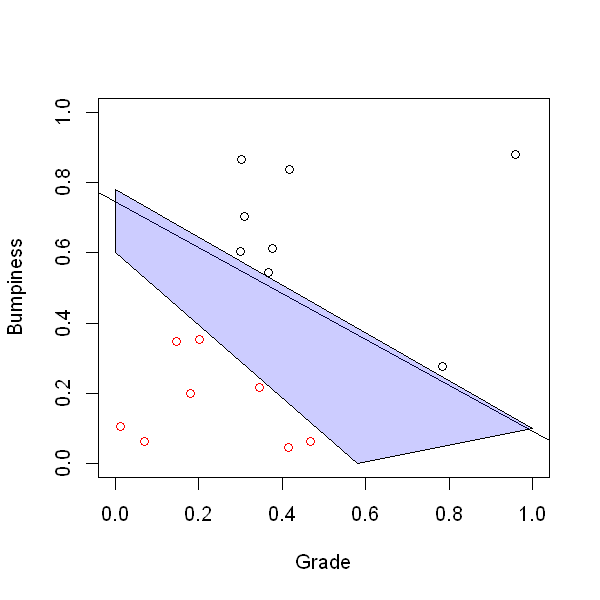

In [7]:
plot(Bumpiness ~ Grade, col=Speed, speedsub,xlim=c(0,1),ylim=c(0,1))
abline(-model[1]/model[3], -model[2]/ model[3])
polygon(c(.58,1,0,0),c(0,.1,.78,.6),col=rgb(0,0,1,0.2))

Note that the line isn't very good - remember that we only used a subset of the data to fit the decision boundary. But it still lies in the expected range.

There is another way we could plot this: we could split our figure into small boxes, then make a prediction for each box. We then plot all the decisions in two different colors, showing the prediction for each box. This gives us a more general tool for plotting not only linear boundaries, but any possible decision boundary.

Warning message:
"package 'pracma' was built under R version 3.3.3"

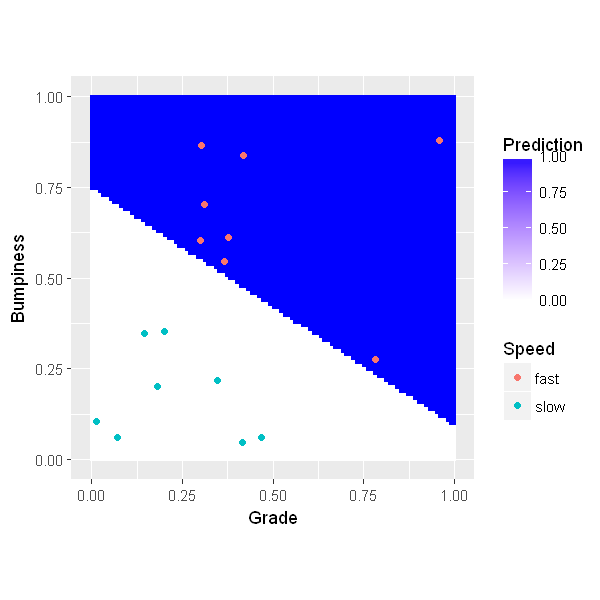

In [8]:
library(pracma)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh
x_min <- 0.0; x_max <- 1.0 # Mesh x size
y_min <- 0.0; y_max <- 1.0  # Mesh y size
h <- .01  # step size in the mesh
mesh<-meshgrid(seq(x_min,x_max,h),seq(y_min,y_max,h))

mesh$Z <- ((model[1] + model[2]*mesh$X + model[3]*mesh$Y < 0)*1)

library(ggplot2)
meshdf <- data.frame(Grade=c(mesh$X),Bumpiness=c(mesh$Y),Prediction=c(mesh$Z))

p <- ggplot(meshdf, aes(Grade, Bumpiness)) +
 geom_raster(aes(fill = Prediction)) + scale_fill_gradient2(low='white', high='blue')+ coord_fixed()

p + geom_point(aes(Grade,Bumpiness,col=Speed),data=speedsub)


At this point, let's go back to the entire test dataset and fit the decision boundary for it. We'll also look at the out-of-sample performance by plotting the test data instead of the train data.

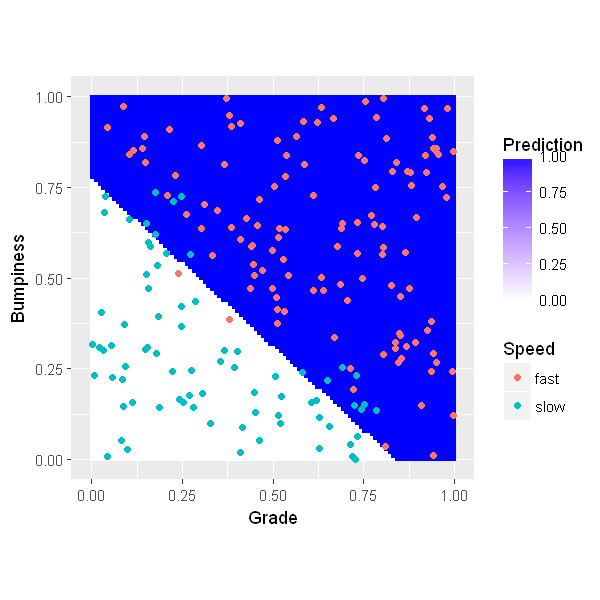

In [9]:
trainIndex <- sample(seq(nrow(speeddf)), nrow(speeddf)*0.8)

train <- speeddf[trainIndex, ]
test <- speeddf[-trainIndex, ]

model2 <- perceptron(train[1:2],(2*as.numeric(train$Speed)-3),0.01,100)

mesh$Z <- ((model2[1] + model2[2]*mesh$X + model2[3]*mesh$Y < 0)*1)

meshdf <- data.frame(Grade=c(mesh$X),Bumpiness=c(mesh$Y),Prediction=c(mesh$Z))

p <- ggplot(meshdf, aes(Grade, Bumpiness)) +
 geom_raster(aes(fill = Prediction)) + scale_fill_gradient2(low='white', high='blue')+ coord_fixed()

p + geom_point(aes(Grade,Bumpiness,col=Speed),data=test)


So, there are a few things to note here. First, the Perceptron has given us a boundary that works fairly well. However, it isn't perfect. There are a few points that are labeled "fast" that will now be classified as "slow". It would be nice to have a way to quantify how well the classifier has performed. We'll look at a new set of tools to do that.

## Evaluation Metrics

First, we review the evaluation metric we've already seen: the RMS value for the linear regression. Recall from Class 02 that we calculated this by taking our model prediction, subtracting the actual value, squaring the difference, then averaging over all points in the test set. Finally, we took the square root of this to get the RMS: "[Square]Root [of the] Mean-Squared". A perfect fit would give an RMS of 0.0 and larger RMS values mean that the fit is not performing as well.

There are more ways to evaluate the performance of a classifier model. They all start with the confusion matrix, so we'll start there.

### The Confusion Matrix

The first thing we do is recognize that there are, for a binary, or two-state classifier, four possible outcomes when we evaluate each test point:
1. The prediction says "slow" and the actual label says "slow"
2. The prediction says "fast", but the actual label says "slow"
3. The prediction says "slow", but the actual label says "fast"
1. The prediction says "fast" and the actual label says "fast"


The first and last possibilies indicate that the prediction did a good job, but the other two mean there were problems. Let's make this into a table:


|           | | Predicted | Predicted|
|:--------: |:-----:|:-----:|:-----:|
|  | |  Slow | Fast | 
|**Actual**	|Slow | #1  | #2 |
|**Actual**	| Fast | #3 | #4 | | 

Now we need to count how many of each possibility there were using the test data. There is, naturally, a tool to do this for us.


In [10]:
library(caret)
predict.perceptron <- function(x,y){
    rawpred <- ifelse(model2[1] + model2[2]*x + model2[3]*y > 0 ,'slow','fast')
    pred <- factor(rawpred,levels=c('fast','slow'))
    return(pred)
}

pred <- mapply(predict.perceptron,test$Grade,test$Bumpiness)
cm<-confusionMatrix(pred,test$Speed)
cm$table

Loading required package: lattice


          Reference
Prediction fast slow
      fast  122   14
      slow    2   62

We can also visualize this as a graphic, showing a shade of color for each of the different values. This is especially useful when we have more than two classes. Because we'll use this again, we define a function that takes the class labels and confusion matrix as inputs and creates the plot.

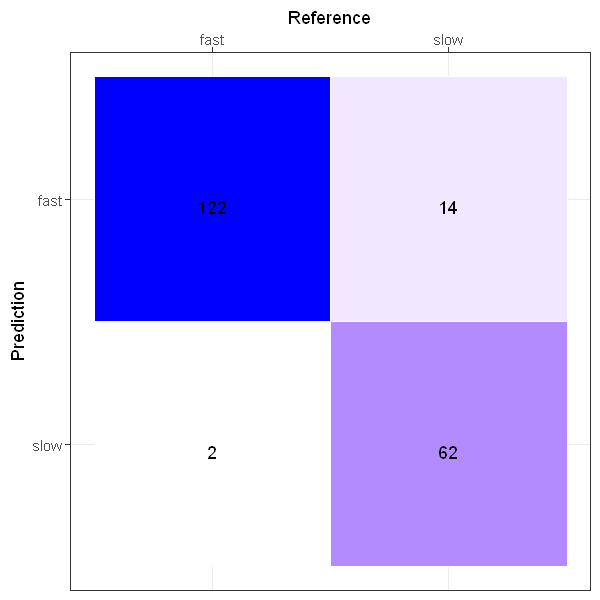

In [11]:
Reference <- factor(c('fast', 'fast', 'slow', 'slow'))
Prediction <- factor(c('fast', 'slow', 'fast', 'slow'),levels=rev(levels(test$Speed)))
df <- data.frame(Reference, Prediction, Y=c(cm$table))

ggplot(data =  df, mapping = aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Y), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  theme_bw() + theme(legend.position = "none") + scale_x_discrete(position = "top")

We can see now that the diagonal entries are what we want- the darker they are, the better we are doing. The off-diagonal terms (the slow-fast and fast-slow terms) are points that have been incorrectly identified. It would be nice if we could distill this matrix down into a single number. Unfortunately, there is no unique way of doing that. There are a couple of different metrics that people use and we can quickly go through them. There is a nice summary [here](http://www.kdnuggets.com/2016/12/best-metric-measure-accuracy-classification-models.html) of some of the metrics and how people use them. The `confusionMatrix()` function actually calculated these for us.

#### Class-dependent Metrics

The set of metrics depend on what your target is. For example, with the Sensitivity/Recall score, the goal is to either correctly predict when to go slow or to correctly predict when to go fast.

#### Class-independent Metrics

The last set of metrics take all the possibilities into account and wrap them up as a single number. Which metric you use is something of a personal preference. However, it is good practice to use the same metric when comparing different models.

In [12]:
cm$byClass

Sensitivity          Specificity       Pos Pred Value 
           0.9838710            0.8157895            0.8970588 
      Neg Pred Value            Precision               Recall 
           0.9687500            0.8970588            0.9838710 
                  F1           Prevalence       Detection Rate 
           0.9384615            0.6200000            0.6100000 
Detection Prevalence    Balanced Accuracy 
           0.6800000            0.8998302

In [13]:
cm$overall

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  9.200000e-01   8.248687e-01   8.733351e-01   9.535824e-01   6.200000e-01 
AccuracyPValue  McnemarPValue 
  2.345196e-22   5.959526e-03

The Perceptron is typically slow and not very flexible. With a large dataset it takes a long time to reach a solution. Altough it is simple to implement, it isn't very good and isn't used much. We'll do one more  classifier to compare the two.

## Naïve Bayes 

We'll now try the Naïve Bayes classifier. If you are interested in *how* the classifier works, I suggest either [this tutorial](http://www.cs.ucr.edu/~eamonn/CE/Bayesian%20Classification%20withInsect_examples.pdf) or reading the [Wikipedia page.](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). We'll stick to the application and evaluation of the model. One of the advantages of the Naïve Bayes classifier is that it isn't fixed to a linear decision boundary. That means we can account for curved boundaries and maybe do a little bit better than the Perceptron.

We use the same set of training/testing features and labels as we used with the Perceptron. That will give us a head-to-head comparison between the two models.

Warning message:
"package 'e1071' was built under R version 3.3.3"
Attaching package: 'e1071'

The following object is masked from 'package:pracma':

    sigmoid



          Reference
Prediction fast slow
      fast  122   21
      slow    2   55


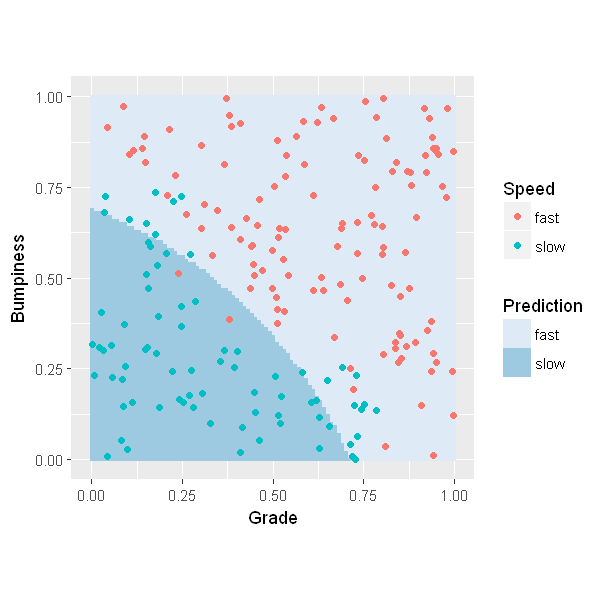

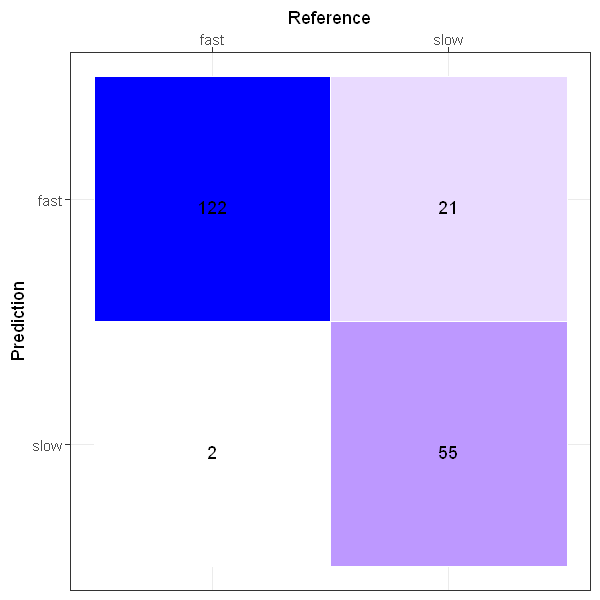

In [14]:
library(e1071)

nbmodel <- naiveBayes(Speed ~ ., data = train)

h <- .01  # step size in the mesh
mesh<-meshgrid(seq(x_min,x_max,h),seq(y_min,y_max,h))
meshdf <- data.frame(Grade=c(mesh$X),Bumpiness=c(mesh$Y))
meshdf$Prediction <- predict(nbmodel,meshdf)


p <- ggplot(meshdf, aes(Grade, Bumpiness)) + 
geom_raster(aes(fill = Prediction)) + coord_fixed() + scale_fill_brewer(palette=1)

p + geom_point(aes(Grade,Bumpiness,col=Speed),data=test)

# Plot Confusion Matrix
pred <- predict(nbmodel,test)
cm<-confusionMatrix(pred,test$Speed)
print(cm$table)

Reference <- factor(c('fast', 'fast', 'slow', 'slow'))
Prediction <- factor(c('fast', 'slow', 'fast', 'slow'),levels=rev(levels(test$Speed)))
df <- data.frame(Reference, Prediction, Y=c(cm$table))

ggplot(data =  df, mapping = aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Y), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  theme_bw() + theme(legend.position = "none") + scale_x_discrete(position = "top")

There are a couple of things to note here: first: the decision boundary is curved! However, it is a fairly simple curve in that it doesn't wiggle very much - it is a smooth arc. This is related to the class Learning Principle of Occam's Razor. A straight-line is the simplest possible decision boundary and, therefore, is valued highly from the perspective of keeping the model as simple as possible. A smooth curve is slightly more complicated, but still fairly simple. The question is: do we gain out-of-sample performance by adding in the complexity of making the decision boundary curve? 

That brings us to the second point: the confusion matrix now shows us that we have mis-classified 23 points. We compare that to the Perceptron model where we mis-classified 16 points. So we've done a little bit worse in terms of out-of-sample performance. Let's take a look at the other metrics to see how they compare.

In [15]:
print(cm$byClass)
print(cm$overall)

         Sensitivity          Specificity       Pos Pred Value 
           0.9838710            0.7236842            0.8531469 
      Neg Pred Value            Precision               Recall 
           0.9649123            0.8531469            0.9838710 
                  F1           Prevalence       Detection Rate 
           0.9138577            0.6200000            0.6100000 
Detection Prevalence    Balanced Accuracy 
           0.7150000            0.8537776 
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  8.850000e-01   7.435326e-01   8.324531e-01   9.256866e-01   6.200000e-01 
AccuracyPValue  McnemarPValue 
  4.262708e-17   1.745500e-04 


The differences between the Naïve Bayes classifier and the Perceptron are not very big- on this dataset the Perceptron looks like it might perform just a little better.

On the other hand, the Naïve Bayes classifier is a faster algorithm and handles large datasets better. It also gives us one additional piece of information that can be useful: it will tell us the prediction probabilities for each test point. That will give us access to another metric that can be useful.

### Prediction Probabilities

When we make a prediction on one of the test features, the Naïve Bayes classifier will not only tell us its prediction for what the label should be, it will also tell us with what probability it thinks that label is correct. For example, we input in the following values to get the prediction.

In [16]:
print("Input Values")
test[1,]

[1] "Input Values"


,Grade,Bumpiness,Speed
8,0.3835441,0.9184926,fast


In [17]:
print("Prediction")
predict(nbmodel,test[1,])

[1] "Prediction"


[1] fast
Levels: fast slow

How confident is the model of that prediction? Let's get the prediction proabilities for that point.

In [18]:
predict(nbmodel,test[1,],type="raw")

fast,slow
0.9699369,0.03006309


So, we can see that, for this point, the model outputs a 97% chance that the point should be classified as "fast" and, therefore, a 3% chance that it is "slow". We can plot the confidence intervals for these points to show how the model is mapping input values to output values. 

In [19]:
test$FastProb <- (predict(nbmodel,test,type="raw"))[,1]

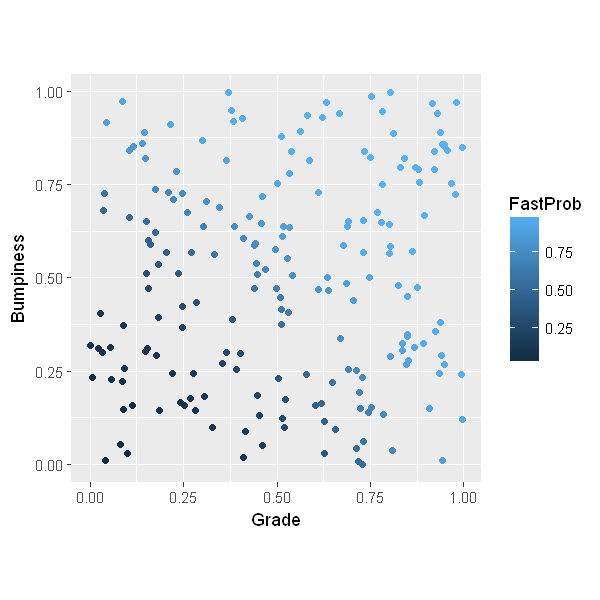

In [20]:
ggplot(test) + geom_point(aes(Grade,Bumpiness,col=FastProb))+ coord_fixed() 

So we see that the model has a pretty high probabily of getting the label correct in both corners, but closer to the decision boundary the probability of each label approaches the midpoint of 50%.

### Logloss Metric

We've got one more metric we can use for models that give us access to the prediction probabilities. This metric has the property that if all the points are correctly predicted, it will be 0.0. The closer to zero you are, the better the model is doing at predicting the correct outcomes. It is a class-independent metric and works for models with more than two classes, too.

In [21]:
library(MLmetrics)
LogLoss(y_pred = test$FastProb, y_true = 2-as.numeric(test$Speed))

Warning message:
"package 'MLmetrics' was built under R version 3.3.3"
Attaching package: 'MLmetrics'

The following object is masked from 'package:base':

    Recall



[1] 0.2522786

# Assignment

You assignment this week is to run through both the Perceptron and the Naïve Bayes classifiers with your classification data. Evaluate both models using each of the metrics we've learned about and compare the performance of the models.

If you find that the model fit is taking a long time, you should note that in your assignment as well. How long a model takes to learn is an important parameter. There is a simple way of timing the model performance. We'll run both models again and compare their timing. For the small number of data points we have in this dataset, the timing isn't very different. That may not be the case for your models.

In [22]:
# Perceptron Model
start.time <- Sys.time()
model2 <- perceptron(train[1:2],(2*as.numeric(train$Speed)-3),0.01,100)
end.time <- Sys.time()
time.taken <- end.time - start.time
print(paste("Elapsed time:",time.taken,"seconds"))

[1] "Elapsed time: 5.43552017211914 seconds"


In [23]:
# Naïve Bayes model
start.time <- Sys.time()
nbmodel <- naiveBayes(Speed ~ ., data = train)
end.time <- Sys.time()
time.taken <- end.time - start.time
print(paste("Elapsed time:",time.taken,"seconds"))

[1] "Elapsed time: 0.00398397445678711 seconds"
